# Notebook for [Pytorch Dataloader for Image GT dataset](https://stackoverflow.com/questions/59467781/pytorch-dataloader-for-image-gt-dataset)

<!--<badge>--><a href="https://colab.research.google.com/github/trsvchn/stackoverflow-notebooks/blob/master/custom-vision-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [1]:
%matplotlib inline

We need some data with particular structure consisting of 2 folders: RGB and GT.

In [2]:
import os
import numpy as np
from PIL import Image
from PIL import ImageDraw 

root = '/storage/locnx/VisDrone/train'
sub1 = 'trainimg'
sub2 = 'trainimgr'

# for dir_ in dirs:
#     if not os.path.exists(dir_):
#         os.makedirs(dir_)

# # Generate some images
# n = 8
# for i in range(n):
#     arr = np.zeros((32, 32, 3))

#     arr[:,:,:] = np.random.randint(0, 255, 3)
#     im1 = Image.fromarray(np.uint8(arr))
#     # Add some text
#     ImageDraw.Draw(im1).text((0, 0), 'RGB',(255, 255, 255))
#     im1.save(os.path.join(rgb, f'img{i+1}.png'))

#     im2 = Image.fromarray(np.uint8(arr))
#     ImageDraw.Draw(im2).text((0, 0), 'GT',(255, 255, 255))
#     im2.save(os.path.join(gt, f'img{i+1}.png'))

I think, the good starting point is to use `VisionDataset` class as a base. Here is what we are going to use: [DatasetFolder source code](https://github.com/pytorch/vision/blob/d2c763e14efe57e4bf3ebf916ec243ce8ce3315c/torchvision/datasets/folder.py#L57). So, we going to create smth similar. You can notice this class depends on two other functions from  `datasets.folder` module: [default_loader](https://github.com/pytorch/vision/blob/d2c763e14efe57e4bf3ebf916ec243ce8ce3315c/torchvision/datasets/folder.py#L169) and [make_dataset](https://github.com/pytorch/vision/blob/d2c763e14efe57e4bf3ebf916ec243ce8ce3315c/torchvision/datasets/folder.py#L35).

We are not going to modify `default_loader`, because it's already fine, it just helps us to load images, so we will import it.

But we need a new `make_dataset` function, that prepared the right pairs of images from root folder. Since original `make_dataset` pairs images (image paths if to be more precisely) and their root folder as target class (class index) and we have a list of `(path, class_to_idx[target])` pairs, but we need `(rgb_path, gt_path)`. Here is the code for new `make_dataset`:

In [3]:
def make_dataset(root: str, sub1: str, sub2: str) -> list:
    """Reads a directory with data.
    Returns a dataset as a list of tuples of paired image paths: (rgb_path, gt_path)
    """
    dataset = []

    # Our dir names
    # vis_dir = 'trainimg'
    # ir_dir = 'trainimgr'   
    

    # Get all the filenames from RGB folder
    vis_fnames = sorted(os.listdir(os.path.join(root, sub1)))
    
    # Compare file names from GT folder to file names from RGB:
    for ir_fname in sorted(os.listdir(os.path.join(root, sub2))):

            if ir_fname in vis_fnames:
                # if we have a match - create pair of full path to the corresponding images
                vis_path = os.path.join(root, sub1, ir_fname)
                ir_path = os.path.join(root, sub2, ir_fname)

                item = (vis_path, ir_path)
                # append to the list dataset
                dataset.append(item)
            else:
                continue

    return dataset

What do we have now? Let's compare our function with original one:

In [4]:
from torchvision.datasets.folder import make_dataset as make_dataset_original


# dataset_original = make_dataset_original(root, {sub1: 0, sub2: 1}, extensions='png')
dataset = make_dataset(root, sub1, sub2)

# print('Original make_dataset:')
# print(*dataset_original, sep='\n')

print('Our make_dataset:')
print(*dataset, sep='\n')

Our make_dataset:
('/storage/locnx/VisDrone/train/trainimg/00001.jpg', '/storage/locnx/VisDrone/train/trainimg/00001.jpg')
('/storage/locnx/VisDrone/train/trainimg/00002.jpg', '/storage/locnx/VisDrone/train/trainimg/00002.jpg')
('/storage/locnx/VisDrone/train/trainimg/00003.jpg', '/storage/locnx/VisDrone/train/trainimg/00003.jpg')
('/storage/locnx/VisDrone/train/trainimg/00004.jpg', '/storage/locnx/VisDrone/train/trainimg/00004.jpg')
('/storage/locnx/VisDrone/train/trainimg/00005.jpg', '/storage/locnx/VisDrone/train/trainimg/00005.jpg')
('/storage/locnx/VisDrone/train/trainimg/00006.jpg', '/storage/locnx/VisDrone/train/trainimg/00006.jpg')
('/storage/locnx/VisDrone/train/trainimg/00007.jpg', '/storage/locnx/VisDrone/train/trainimg/00007.jpg')
('/storage/locnx/VisDrone/train/trainimg/00008.jpg', '/storage/locnx/VisDrone/train/trainimg/00008.jpg')
('/storage/locnx/VisDrone/train/trainimg/00009.jpg', '/storage/locnx/VisDrone/train/trainimg/00009.jpg')
('/storage/locnx/VisDrone/train/train

Now we can define our class Dataset. The most important part here is `__getitem__` methods, because it imports images, applies transformation and returns a tensors, that can be used by dataloaders. We need to read a pair of images (rgb and gt) and return a tuple of 2 tensor images:

In [5]:
from torchvision.datasets.folder import default_loader
from torchvision.datasets.vision import VisionDataset
from torchvision import transforms
from pathlib import Path  


class CustomVisionDataset(VisionDataset):
    
    def __init__(self,
                 root,
                 subfolder1,
                 subfolder2,
                 loader=default_loader):
        super().__init__(root)

        # Prepare dataset
        samples = make_dataset(self.root, subfolder1, subfolder2)

        self.loader = loader
        self.samples = samples
        # list of RGB images
        self.vis_samples = [s[1] for s in samples]
        # list of GT images
        self.ir_samples = [s[1] for s in samples]
        
        self.transform = transforms.Compose([
            transforms.CenterCrop((512,640)),
            transforms.ToTensor(),
        ])


    def __getitem__(self, index):
        """Returns a data sample from our dataset.
        """
        # getting our paths to images
        vis_path, ir_path = self.samples[index]
        
        # import each image using loader (by default it's PIL)
        vis_sample = self.loader(vis_path)
        ir_sample = self.loader(ir_path)
        
        vis_sample = vis_sample.convert('L')
        ir_sample = ir_sample.convert('L')
        
        # here goes tranforms if needed
        # maybe we need different tranforms for each type of image
        vis_sample = self.transform(vis_sample)
        ir_sample = self.transform(ir_sample)
        
        #get name for sure
        vis_name = Path(vis_path).name
        ir_name = Path(ir_path).name

        # now we return the right imported pair of images (tensors)
        return vis_sample, ir_sample, vis_name, ir_name

    def __len__(self):
        return len(self.samples)

Let's test it:

batch 1:
torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
06448.jpg
06448.jpg


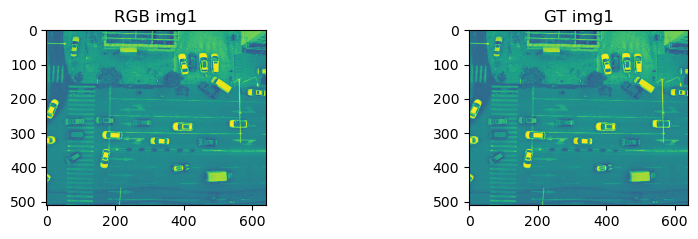

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
17918.jpg
17918.jpg


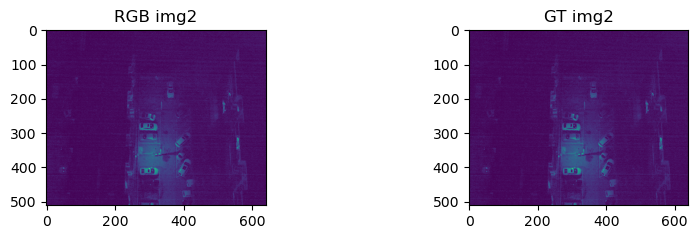

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
07216.jpg
07216.jpg


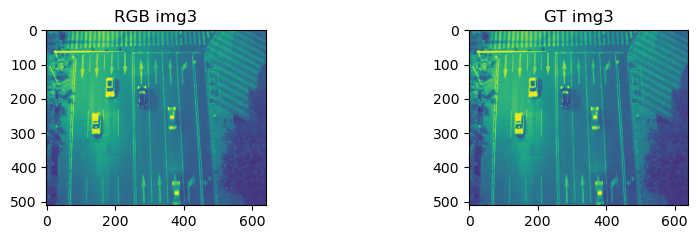

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
13149.jpg
13149.jpg


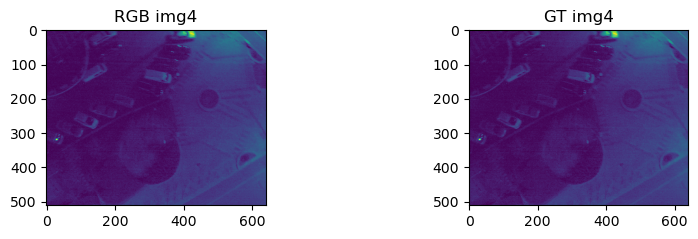

batch 2:
torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
00707.jpg
00707.jpg


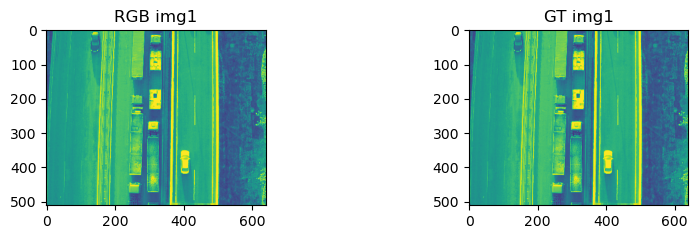

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
06218.jpg
06218.jpg


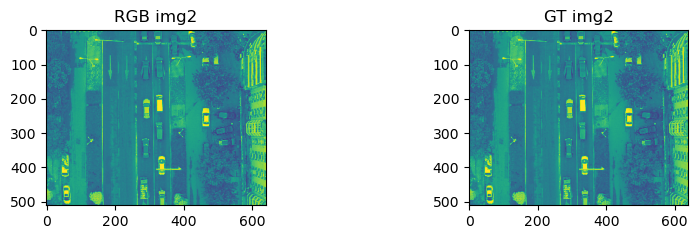

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
05128.jpg
05128.jpg


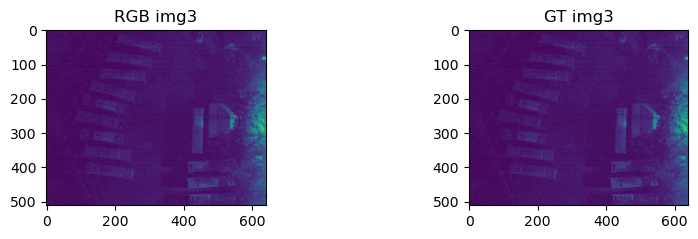

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
00158.jpg
00158.jpg


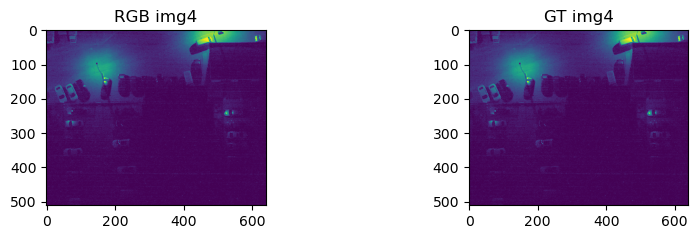

batch 3:
torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
02571.jpg
02571.jpg


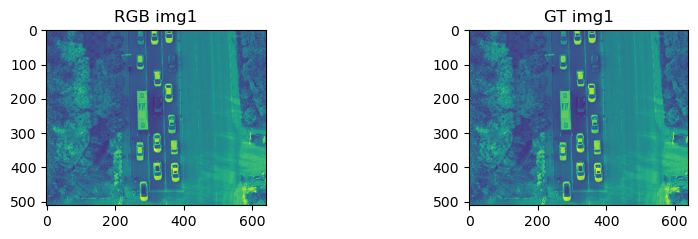

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
11957.jpg
11957.jpg


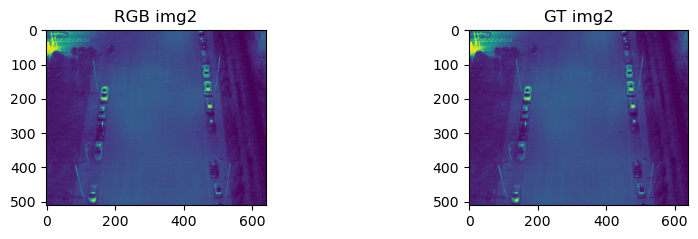

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
12543.jpg
12543.jpg


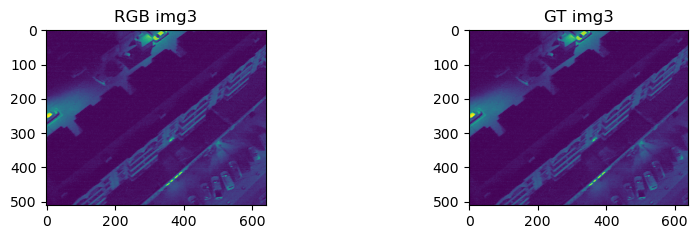

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
10645.jpg
10645.jpg


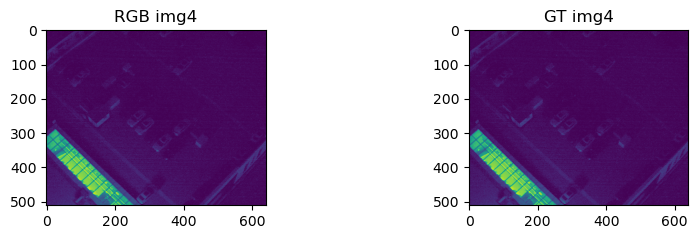

batch 4:
torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
13139.jpg
13139.jpg


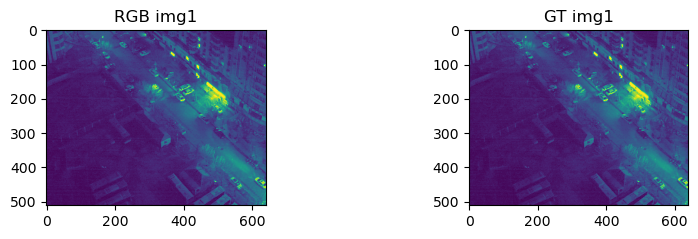

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
10562.jpg
10562.jpg


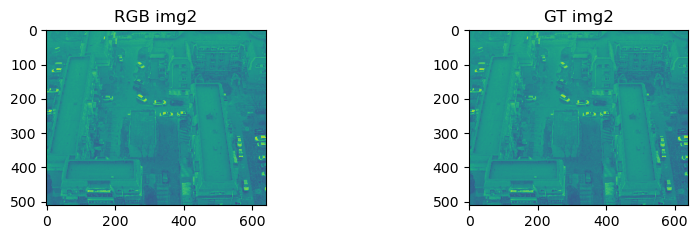

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
16978.jpg
16978.jpg


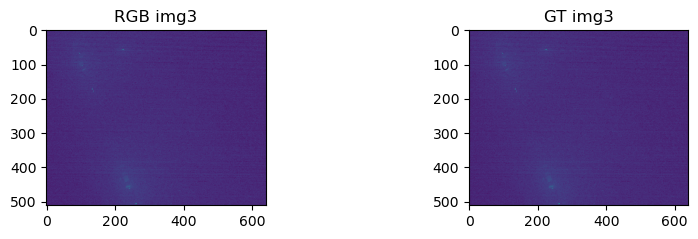

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
09193.jpg
09193.jpg


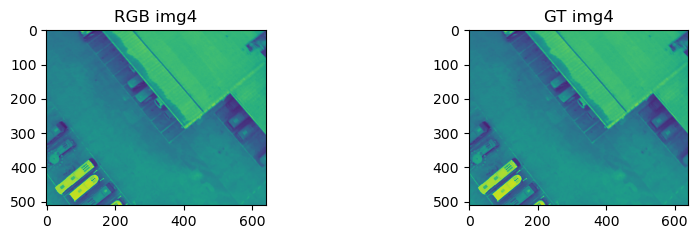

batch 5:
torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
02095.jpg
02095.jpg


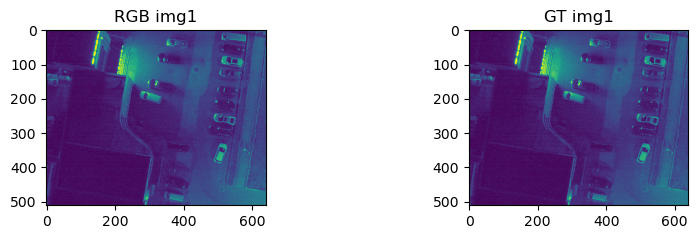

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
01880.jpg
01880.jpg


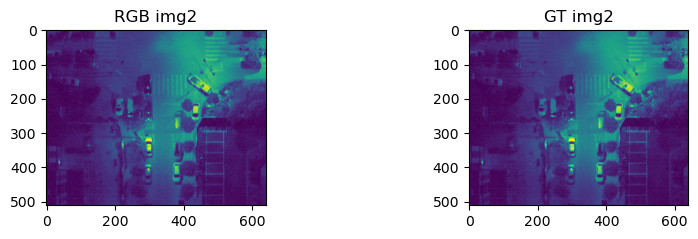

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
09196.jpg
09196.jpg


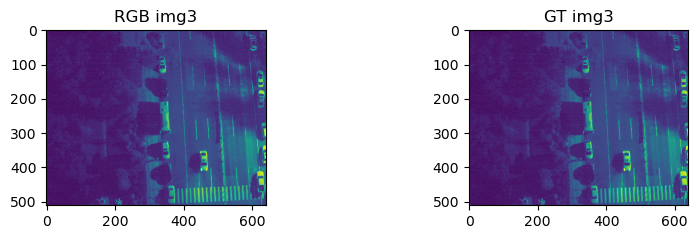

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
00254.jpg
00254.jpg


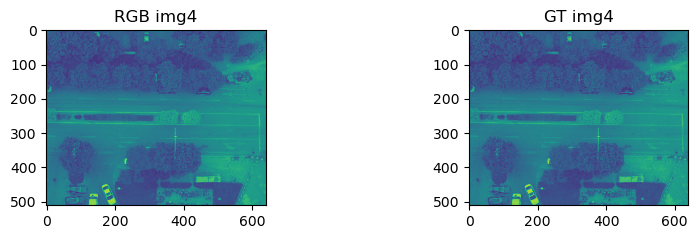

batch 6:
torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
03059.jpg
03059.jpg


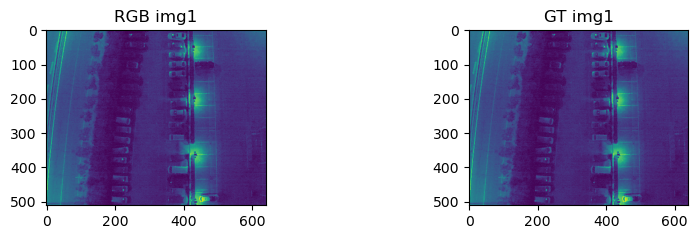

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
15400.jpg
15400.jpg


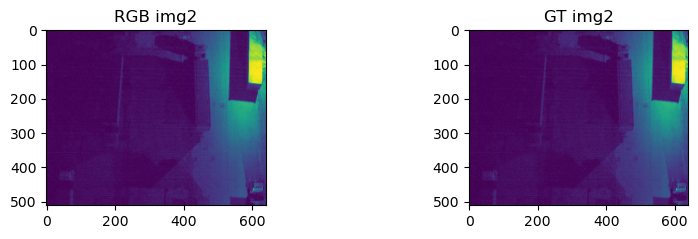

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
17392.jpg
17392.jpg


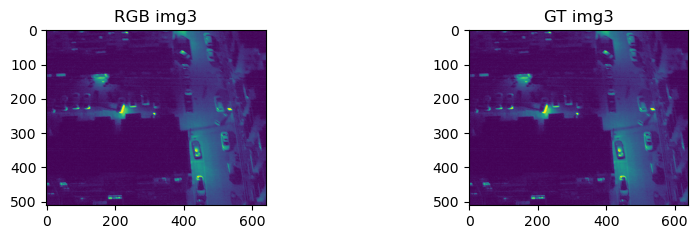

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
17467.jpg
17467.jpg


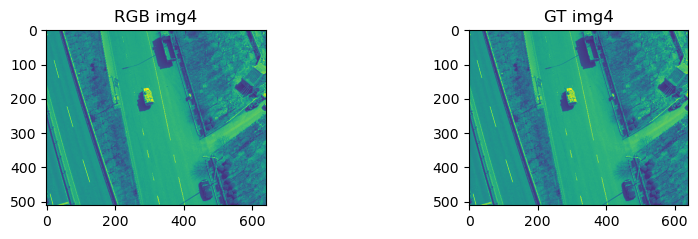

batch 7:
torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
06209.jpg
06209.jpg


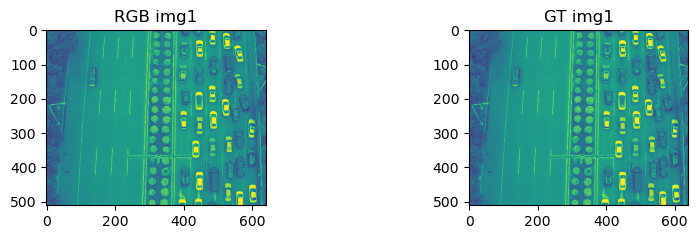

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
08882.jpg
08882.jpg


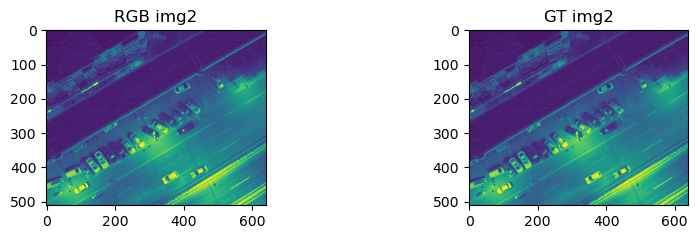

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
06083.jpg
06083.jpg


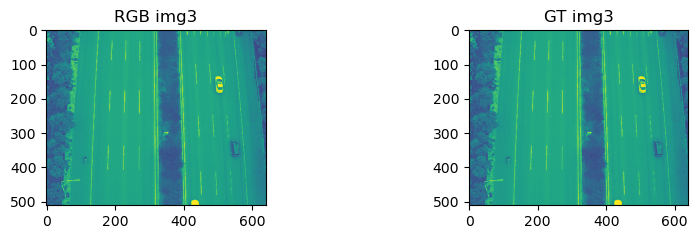

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
17409.jpg
17409.jpg


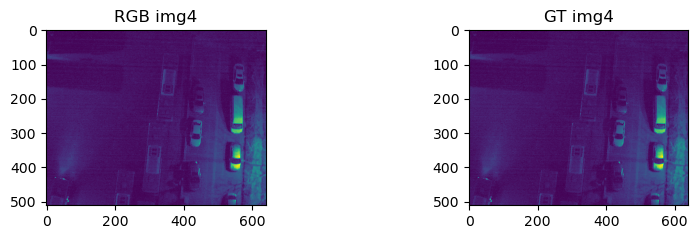

batch 8:
torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
15124.jpg
15124.jpg


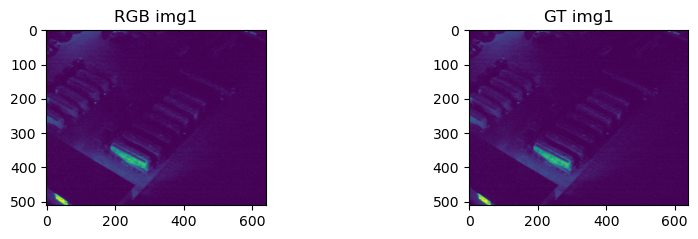

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
08201.jpg
08201.jpg


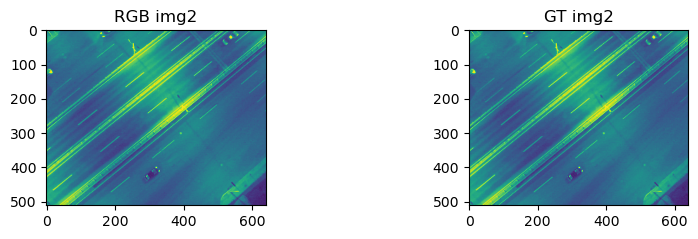

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
05855.jpg
05855.jpg


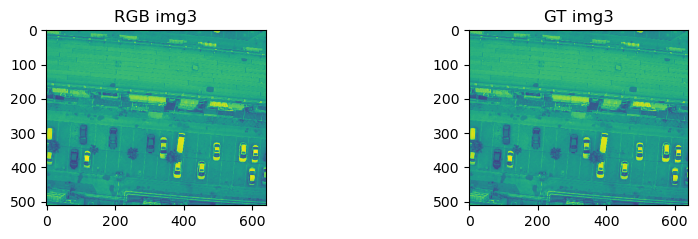

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
00700.jpg
00700.jpg


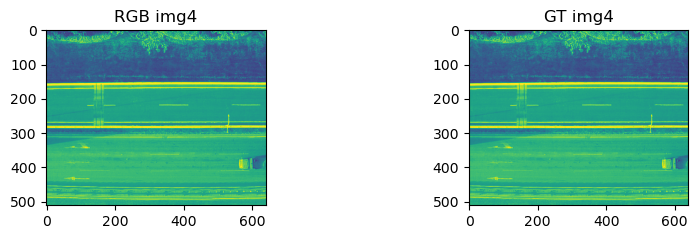

batch 9:
torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
03862.jpg
03862.jpg


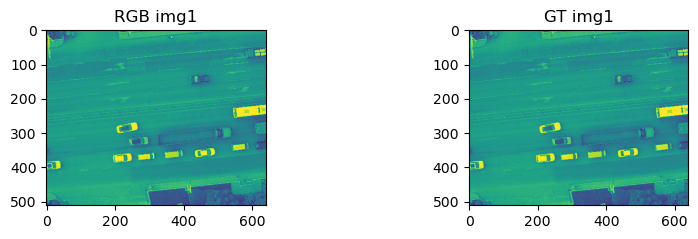

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
07852.jpg
07852.jpg


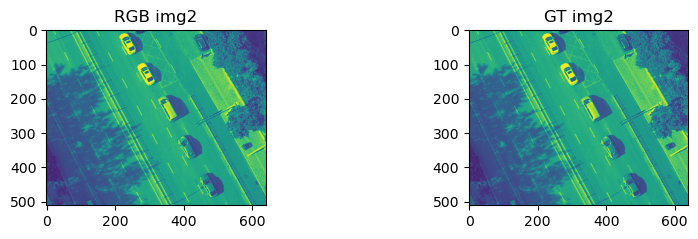

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
13427.jpg
13427.jpg


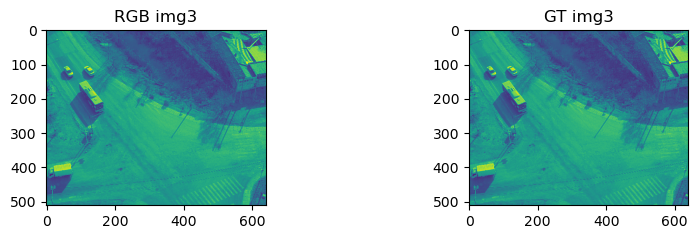

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
00820.jpg
00820.jpg


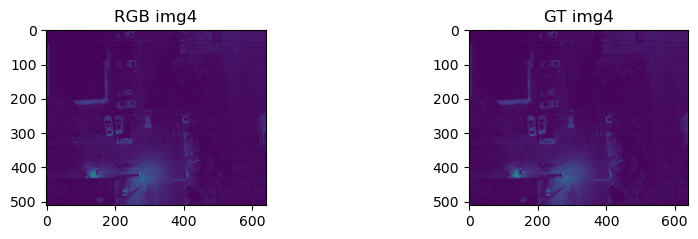

batch 10:
torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
03749.jpg
03749.jpg


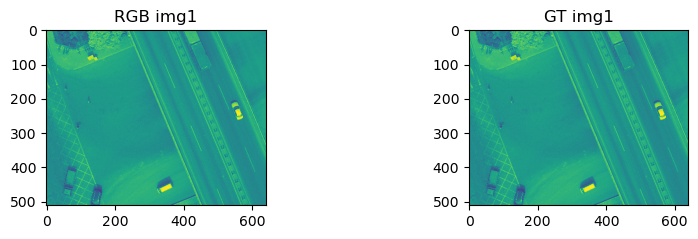

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
13438.jpg
13438.jpg


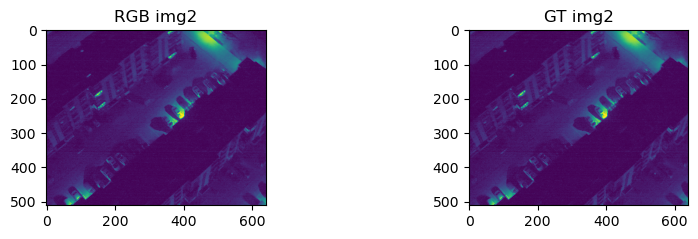

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
15063.jpg
15063.jpg


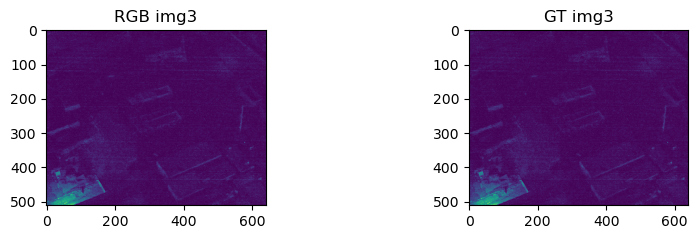

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
00990.jpg
00990.jpg


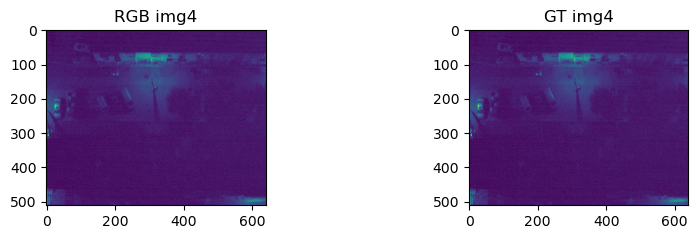

batch 11:
torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
13560.jpg
13560.jpg


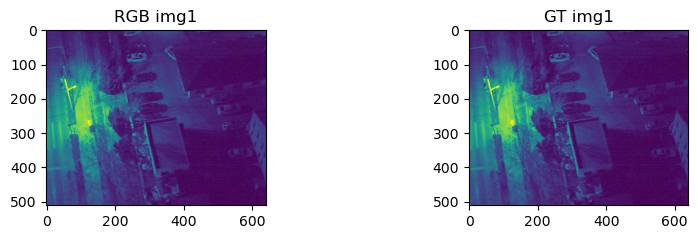

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
11667.jpg
11667.jpg


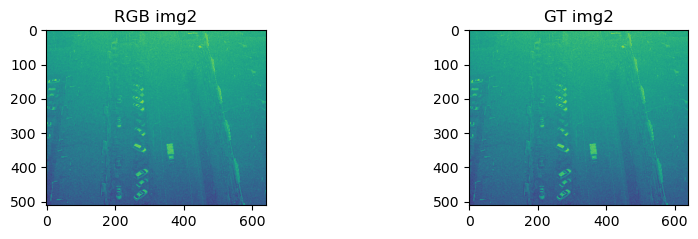

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
10100.jpg
10100.jpg


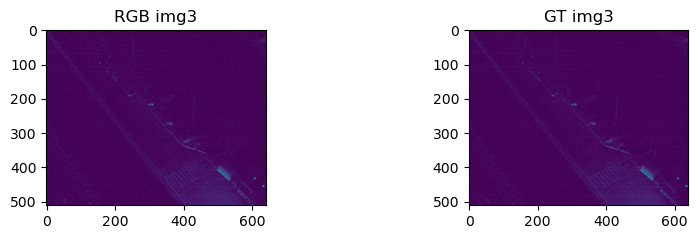

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
09649.jpg
09649.jpg


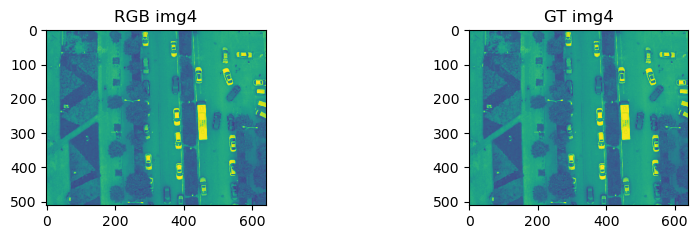

batch 12:
torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
13694.jpg
13694.jpg


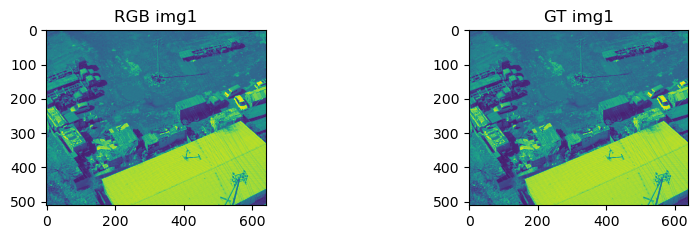

In [ ]:
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


bs=4 # batch size
# transforms = ToTensor()  # we need this to convert PIL images to Tensor
shuffle = True

dataset = CustomVisionDataset(root, sub1, sub2)
dataloader = DataLoader(dataset, batch_size=bs, shuffle=shuffle)

for i, (rgb, gt, rp, gtp) in enumerate(dataloader):
    print(f'batch {i+1}:')
    # some plots
    for i in range(bs):
        print(rgb[i].shape)
        print(gt[i].shape)
        print(rp[i])
        print(gtp[i])
        
        plt.figure(figsize=(10, 5))
        plt.subplot(221)
        plt.imshow(rgb[i].squeeze()[1:])
        plt.title(f'RGB img{i+1}')
        plt.subplot(222)
        plt.imshow(gt[i].squeeze()[1:])
        plt.title(f'GT img{i+1}')
        plt.show()